# Testing Colormaps

In this notebook we implement some of Peter Kovesi's proposed colormap tests, and try them out on some new maps. In particular, we're interested in the performance of:

1. Diverging color tables made from two concatenated converging color tables 
2. A "random linear" color table, designed to look like a linear grayscale when printed in black and white, but incomprehensible when seen on a color display.


### Requirements

#### Packages

You'll need `matplotlib`, but that's about it.

In [1]:
# Use inline for development:
# %matplotlib inline  

# Use agg to save pngs and display grayscale versions alongside:
import matplotlib
matplotlib.use('Agg')

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib._cm import cubehelix
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, display

from testcard import *

#### Colormap Test Data

Peter Karpov provides color map data on his website, [here](http://inversed.ru/Blog_2.htm). These are checked in to the `data` folder of this repository.

In [2]:
_hesperia_data = np.loadtxt("data/hesperia.csv", delimiter=",", skiprows=4).tolist()
_laguna_data = np.loadtxt("data/laguna.csv", delimiter=",", skiprows=4).tolist()
_lacerta_data = np.loadtxt("data/lacerta.csv", delimiter=",", skiprows=4).tolist()
_mod_plasma_data = np.loadtxt("data/mod_plasma.csv", delimiter=",", skiprows=4).tolist()

## 1. Diverging Colormaps

First, let's try constructing a diverging color map from concatenating two converging color maps, back to back:

In [3]:
one = _hesperia_data
two = _laguna_data

In [4]:
# Concatenate maps "one" and "two", back to back so that the central value
# is de-emphasized, and make the inverse scale "_r" as well:
center_emph = ListedColormap((one[::-1][:192] + two[1:][64:])[10:-10], name="center_emph")
center_emph_r = ListedColormap(center_emph.colors[::-1], name="center_emph_r")
plt.register_cmap(cmap=center_emph)
plt.register_cmap(cmap=center_emph_r)

# Now do the same thing, but to emphasize the central value instead:
center_deemph = ListedColormap((one[:-1][64:] + two[::-1][:192])[20:-20], name="center_deemph")
center_deemph_r = ListedColormap(center_deemph.colors[::-1], name="center_deemph_r")
plt.register_cmap(cmap=center_emph)
plt.register_cmap(cmap=center_emph_r)

Now make a testcard plot for each one.

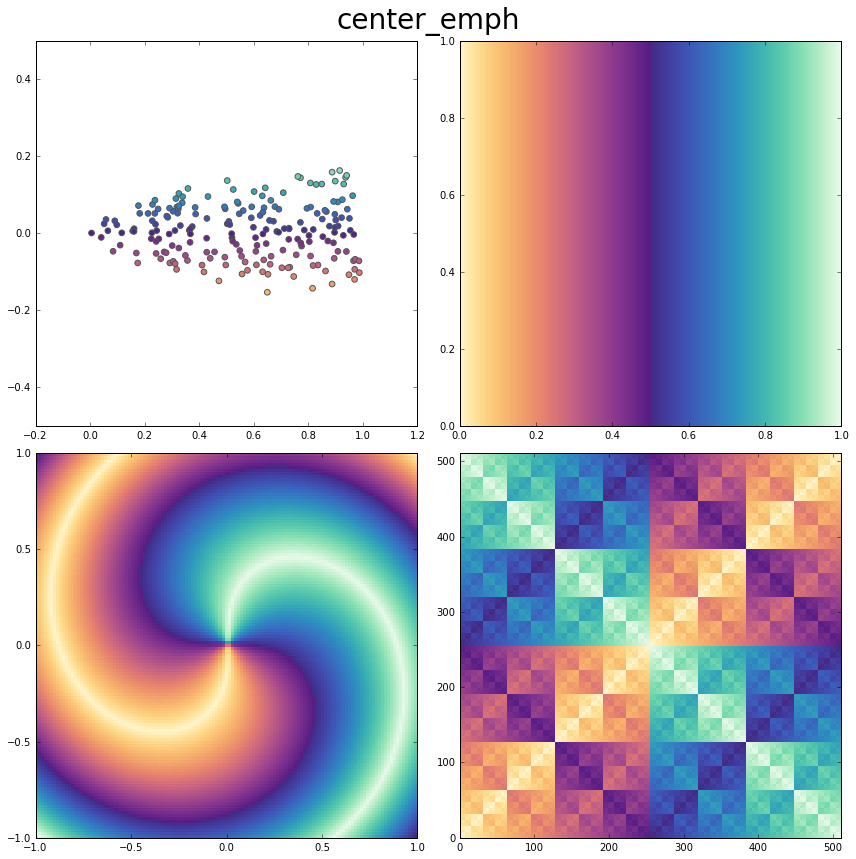

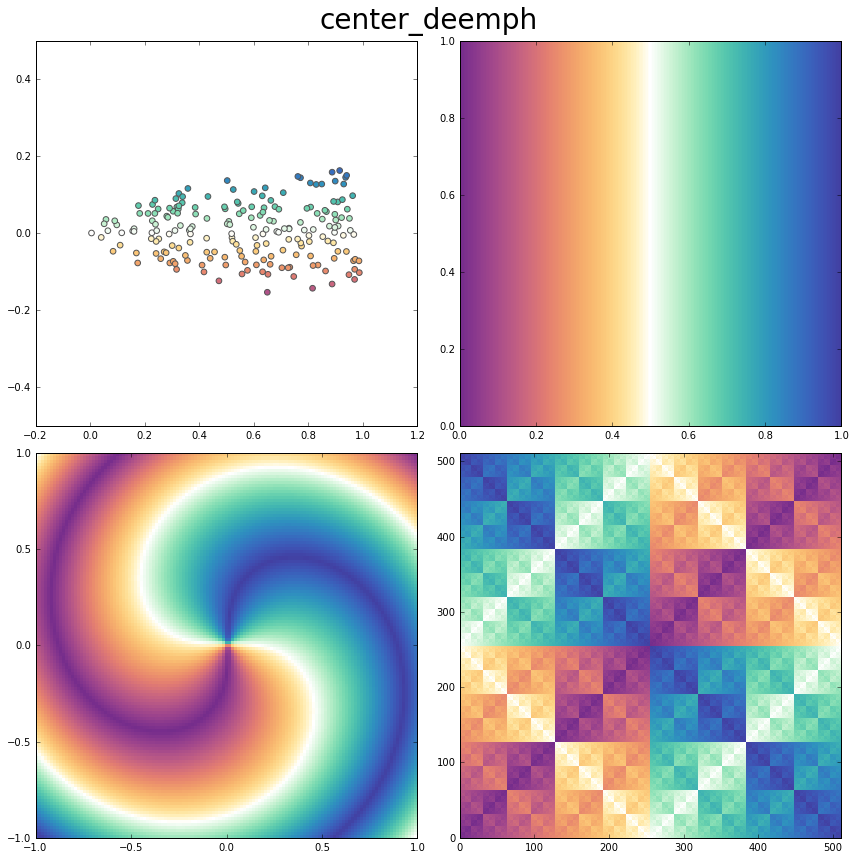

In [33]:
%matplotlib inline
for cmap in [center_emph, center_deemph]:
    fig = testcard(cmap)
    fig.savefig("{}.png".format(cmap.name))

## 2. A "Random Linear" Colormap

Goal: find a color map that appears to be a linear grayscale when viewed (or printed) in black and white, but is as colorful as possible when viewed in color.

### a) Fast `cubehelix`

Could we implement this cheaply by using the `cubehelix` color map, but have it wind so fast that the hue is effectively random?

In [6]:
# Make a cubehelix color map, and re-register it as "fast_cubehelix".

# First get the cubehelix color table, with some large number of rotations:
forward = cubehelix(gamma=1.0, s=0.5, r=-37*3.141592654, h=1.0)

# Now register this as a listed color map:
fast_cubehelix = LinearSegmentedColormap("fast_cubehelix", forward, 256)
plt.register_cmap(cmap=fast_cubehelix)

In [7]:
fig = testcard(fast_cubehelix)
fig.savefig('fast_cubehelix.png')

In [8]:
! convert -type Grayscale fast_cubehelix.png fast_cubehelix_bw.png
display(HTML("<table><tr><td><img src='fast_cubehelix.png'></td><td><img src='fast_cubehelix_bw.png'></td></tr></table>"))

,


So this does *not* work, but in a fairly amusing way: the helical path through the RGB cube is too regular, even when it's a very tight spiral, and you get interference effects. 

### b) Random Sampling

Let's try making RGB arrays with the same linear amplitude as `cubehelix`, but otherwise sampling "randomly". We can try to do this by using a linear ramp in "value", and then sampling uniformly on the hue-saturation (disk) plane. Other similar options are to work with the HCL or HSL systems. Alternatively we could just sample the RGB cube and then select samples that have the right intensity. This may need a lot of samples.

First, let's define the transformations that we cannot easily import from elsewhere.

In [9]:
# Utility functions:

def hls_to_rgb(hls): 
    rgb = np.zeros_like(hls)
    import colorsys
    for i in range(len(hls)):
        r,g,b = colorsys.hls_to_rgb(hls[i,0], hls[i,1], hls[i,2])
        rgb[i,:] = np.array([r,g,b])
    
    return rgb


def hcl_to_rgb(hcl):
    perm = np.array([[0,1,2],[1,0,2],[2,0,1],[2,1,0],[1,2,0],[0,2,1]])
    luma_vec = np.array([0.21, 0.72, 0.07])

    h = hcl[:,0]
    c = hcl[:,1]
    y = hcl[:,2]
    
    p = h / 60.0
    x = c * (1.0 - np.abs(np.mod(p, 2.0) - 1.0))
    z = np.zeros_like(x)
    ip = np.int64(p)
    col = np.vstack((c,x,z)).transpose()  
    
    rgb = col[np.tile(np.arange(len(x)), (3,1)).transpose(), perm[ip]]
    
    m = y - np.dot(rgb, luma_vec)
    rgb += m[:,np.newaxis]
    
    # The following is necessary but demonstrates a problems - some RGB vals are hitting cube boundary. 
    rgb = np.clip(rgb, 0, 1, out=rgb)
    
    return rgb

In [29]:
def random_linear(nlev=256,space='rgb',seed=42):
    """
    Make a matplotlib colormap object representing a color table that is linear in intensity but random in RGB.
    
    Parameters
    ----------
    nlev : int, optional
        the desired number of levels in the color table
    space : str
        the space to sample. Options are 'rgb' (default), 'hsv', 'hcl', 'hsl'
    seed : int
        the random seed to use when sampling
    
    Returns
    -------
    cmap : ListedColormap
        a matplotlib colormap object
        
    Notes
    -----
    This function only partially works. The output tables are somehow *not* quite
    linear in intensity, in that they all appear with stripes in them where the 
    increase in intensity is not smooth. This seems to be due to the RGB values 
    hitting the edges of the unit cube (in the hsv, hsl, and hcl cases); when 
    sampling in rgb it's not clear what is going on. The rgb result is still 
    an approximately smooth linear ramp. Oddly, when the rgb PNG file is converted 
    to grayscale using Image Magick's `convert` utility, the resulting testcard
    *does* look like a smooth grayscale image. Until this is understood I recommend
    that you do *not* use this colormap.
    """
    
    np.random.seed(seed)
    
    if space == 'hsv':
        # Warning: uniform sampling in HSV does not work, as the cube is often exceeded:
        val = np.linspace(0.0, 1.0, nlev)
        hue = np.random.random(nlev)
        sat = np.sqrt(np.random.random(nlev))
        hsv = np.vstack([hue, sat, val]).transpose()
        from matplotlib.colors import hsv_to_rgb
        rgb = hsv_to_rgb(hsv)
        
    elif space == 'hcl':
        # HCL has the same problem:
        lum = np.linspace(0.0, 1.0, nlev)
        hue = 360.0 * np.random.random(nlev)
        chm = np.sqrt(np.random.random(nlev))
        hcl = np.vstack([hue, chm, lum]).transpose()
        rgb = hcl_to_rgb(hcl)
  
    elif space == 'hsl':
        # HSL, same story:
        lum = np.linspace(0.0, 1.0, nlev)
        hue = 360.0 * np.random.random(nlev)
        sat = np.sqrt(np.random.random(nlev))    
        hls = np.vstack([hue, lum, sat]).transpose()
        rgb = hls_to_rgb(hls)       
        
    else:
        # Uniformly sample the rgb cube and deal with it (and then lament the non-smooth output)  
        loads = 3000000
        f = lambda r,g,b: 0.21*r + 0.72*g + 0.07*b
        red = np.random.random(loads)
        grn = np.random.random(loads)
        blu = np.random.random(loads)
        I = f(red,grn,blu)
        # print "Uniformly sampling the RGB cube:"
        # print "  red: ", np.min(red), np.max(red)
        # print "  grn: ", np.min(grn), np.max(grn)
        # print "  blu: ", np.min(blu), np.max(blu)
        # print "    I: ", np.min(I),   np.max(I)
        Irgb = np.vstack([I, red, grn, blu]).transpose()
        # Use `histogram` to bin the samples by intensity, and then label the 
        # members of each bin with `digitize`:
        index = np.linspace(0,loads,loads,dtype=int)
        hist, bins = np.histogram(I, bins=nlev)
        levels = np.digitize(I, bins)
        # Select bin members and find the sample closest to the center:
        width = (np.max(I)-np.min(I))/float(nlev)
        residual = np.zeros_like(I)
        selected = range(nlev)  # This is just an int array that we will populate
        for k in range(0,nlev):
            I_target = k * width + 0.5 * width
            j = np.where(levels == k+1)
            if len(j) == 0:
                this = 0
            else:
                residual[j] = I[j] - I_target
                thisindex = index[j] 
                thisbest = np.argmin(np.abs(residual[j]))  # integer index referring to the j subset
                this = thisindex[thisbest]
            # Check intensity:
            thisrgb = Irgb[this][1:4]
            thisI = f(thisrgb[0], thisrgb[1], thisrgb[2])
            # print "Intensity level =",k," will use sample", this, ": I =",I[this], "+/-", residual[this],"cf.",thisI
            assert (thisI - I[this]) < 0.01
            selected[k] = this
        # Pull out these samples, and extract RGB values:
        rgb = Irgb[selected][:,1:4]
    
    # We now have an rgb array, 3 columns by nlev rows, that we can build a color map from:
    return ListedColormap(rgb, name="random_linear")

In [27]:
! rm random_linear*.png
cmap = random_linear(nlev=256,seed=12)
plt.register_cmap(cmap=cmap)
fig = testcard(cmap)
fig.savefig('random_linear.png')

In [28]:
! convert -type Grayscale random_linear.png random_linear_bw.png

<table>
  <tr>
    <td><img src='random_linear.png'></td>
    <td><img src='random_linear_bw.png'></td>
  </tr>
</table>

> You can also do this, in a code cell:
```
display(HTML("<table><tr><td><img src='random_linear.png'></td><td><img src='random_linear_bw.png'></td></tr></table>"))
```
However, the images do not seem to refresh each time the cell is executed.

## Conclusions

1. Visually appealing, diverging colormaps can be made pretty straight forwardly in the manner shown above.
2. It seems to be fairly difficult to generate a randomly-sampled color map that appears as linear grayscale across a range of media (grayscale macbook screen, ImageMagick converted PNG, black and white printout).